# Using PyMC3 to estimate Oil Exploration Success probabilities
Ram Narasimhan


## Example 2

### What is in this Notebook?

This notebook is part of the tutorial series on "Getting Started with Bayesian Analysis." We use pymc3 for the anaysis.

**Problem:**

Oil Exploration is expensive.
Even after a Geological study, it is not certain that a given site will yield oil.
In the last 2 years, a Nigerian Oil Investment company has sponsored 18 attempts.
They’ve had 2 successes and 16 duds.

Should they continue sponsoring these explorations? or Stop?

Question: **How certain can we be that there is at least a 10% chance of finding oil in any given prospective site?**

Data: We have the results of the last 18 drilling attempts. 
- 0 means no oil was found. 
- 1 means oil was discovered.

**Goal:** To build a model to understand the probability of each wildcatting (oil drilling) attempt.

In [1]:
import numpy as np
import theano
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
az.style.use('arviz-darkgrid')

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
exploration_data =  [0,0,0,1,0,0,0,0,0,
                        0,0,0,0,1,0,0,0,0]

In [3]:
with pm.Model() as oil_exploration_model:    
    θ = pm.Beta('θ', alpha=1., beta=1.)    
    y = pm.Bernoulli('y', p=θ, observed=exploration_data)    
    trace = pm.sample(1000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]
Sampling 4 chains, 0 divergences: 100%|██████████████████████████████████████| 16000/16000 [00:17<00:00, 933.16draws/s]
The acceptance probability does not match the target. It is 0.8805165275562004, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9037168937566262, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\Users\ramna\Anaconda3\envs\b2\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B416D74E50>,
      dtype=object)

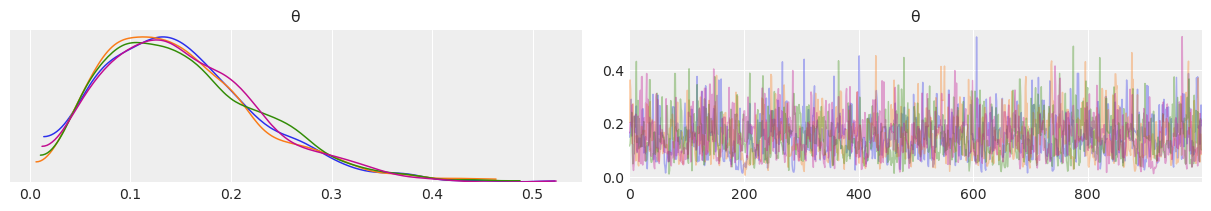

In [4]:
az.plot_trace(trace)

In [5]:
trace.varnames

['θ_logodds__', 'θ']

In [6]:
az.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
θ,0.152,0.077,0.027,0.297,0.002,0.001,1574.0,1574.0,1361.0,1452.0,1.0


In [7]:
#Optional, if you want to really go overboard with Stat summaries

def median_sd(x):
        median = np.percentile(x, 50)
        sd = np.sqrt(np.mean((x-median)**2))
        return sd
    
func_dict = {
    "std": np.std,
    "median_std": median_sd,
    "5%": lambda x: np.percentile(x, 5),
    "median": lambda x: np.percentile(x, 50),
    "95%": lambda x: np.percentile(x, 95),
}

az.summary(trace,
    var_names=["θ"],
    stat_funcs=func_dict
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,std,median_std,5%,median,95%
θ,0.152,0.077,0.027,0.297,0.002,0.001,1574.0,1574.0,1361.0,1452.0,1.0,0.077,0.078,0.048,0.141,0.297


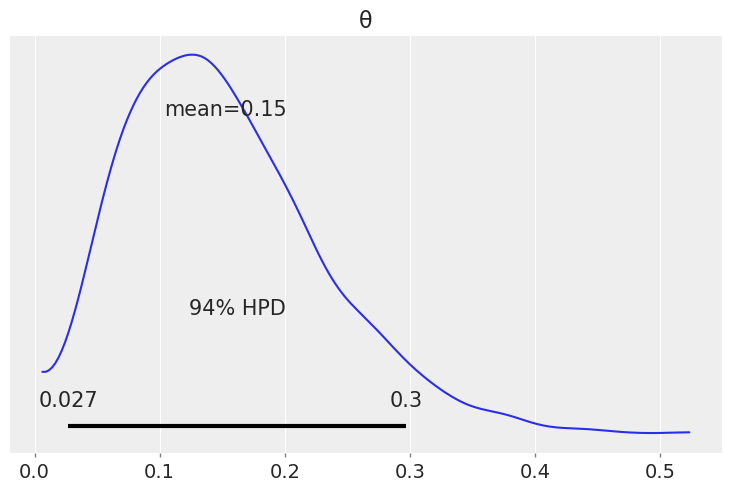

In [8]:
az.plot_posterior(trace);

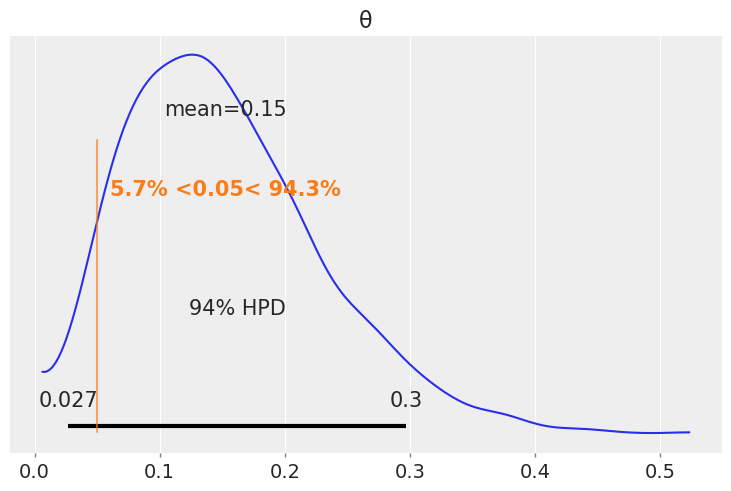

In [9]:
az.plot_posterior(trace, ref_val=0.05);

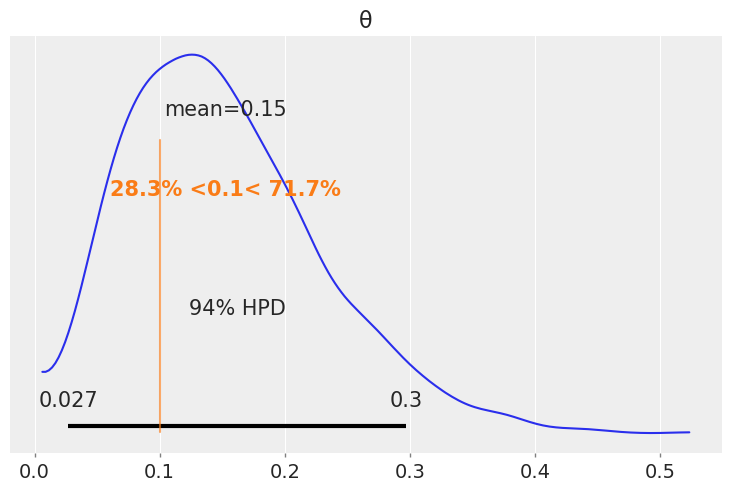

In [10]:
az.plot_posterior(trace, ref_val=0.1);

## Conclusion
By plotting the posterior, and comparing it to a desired reference value, we can see that there is a **71.7%** chance that theta (the true probability of success) is > 0.1
But if the investment firm wants a higher acceptance, then we must advise them to stop sponsoring exploration.

However, if they can accept a 0.05 theta (1 in 20 wells will yield, then we can be **94.3%** confident that it is.


### What might our next few Oil Exploration attempts look like?

This is where we can use Post Predictive Checks can come in handy. We can draw from our trace and examine what we get

In [72]:
 # note this generates (10000, 18) observations
ppc = pm.sample_posterior_predictive(trace, samples=10000, random_seed=2019, model=oil_exploration_model)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3428.19it/s]


The function above randomly draws 10000 samples of parameters from the trace. Then, for each sample, it will draw 18 random Bernoulli tosses, based on the value of theta in that sample.
https://docs.pymc.io/notebooks/posterior_predictive.html

In [87]:
ppc['y'][:]

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0]])

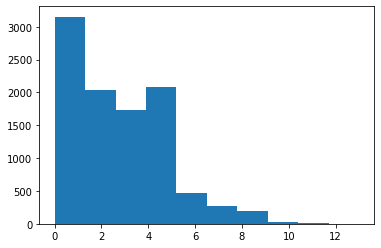

In [102]:
plt.hist(np.sum(ppc['y'], axis=1));

<hr>
<hr>
    
### Bonus Example - Coin Tossing

The idea of resetting data shape (data.set_value is courtesy of Junpeng Lao
- Source: https://discourse.pymc.io/t/revisiting-the-coin-flipping-problem/2714/2


In [34]:
data = theano.shared(np.asarray([0, 0, 0, 0, 0, 1, 1, 1]))

with pm.Model() as coin_flipping:
    p = pm.Uniform('p', lower=0, upper=1)
    y = pm.Bernoulli('y', p=p, observed=data)
    trace = pm.sample(1000, tune=1000)
    # reset value to get the shape right
    data.set_value(np.asarray([0, 0, 0]))
    ppc = pm.sample_posterior_predictive(trace)

np.mean(ppc['y'].sum(axis=1)==3)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
100%|█████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:27<00:00, 143.77it/s]


0.0935

In [44]:
ppc['y'] # 4000 iterations of 3 bernoulli draws

array([[0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 1]])

In [45]:
np.mean(ppc['y'].sum(axis=1)==3)


0.0935

In [46]:
ppc['y'].sum(axis=0)

array([1593, 1591, 1639])

In [47]:
trace.varnames

['p_interval__', 'p']

In [48]:
ppc['y'][:, :3] #Get the first 3 columns of the 2D array in ppc['y']
#if this notation is not clear, read: http://folk.uio.no/inf3330/scripting/doc/python/NumPy/numarray/node26.html

array([[0, 0, 0],
       [1, 0, 0],
       [0, 0, 0],
       ...,
       [0, 1, 0],
       [1, 1, 0],
       [1, 0, 1]])